In [560]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime as dt
import statistics
import dateutil.parser

In [561]:
firstdf = pd.read_csv('EURUSD1m.csv')

firstdf.head()

,Date,Timestamp,Open,High,Low,Close,Volume
0,20100101,11:00:00,1.43327,1.43335,1.43319,1.43335,56.299999
1,20100101,11:01:00,1.43333,1.43333,1.43318,1.43327,82.100001
2,20100101,11:02:00,1.43328,1.43333,1.43319,1.43333,86.900000
3,20100101,11:03:00,1.43325,1.43333,1.43319,1.43326,68.899999
4,20100101,11:04:00,1.43326,1.43333,1.43319,1.43319,45.300000


## Drop useless data/ correcting data

In [562]:
firstdf.columns = map(str.lower, firstdf.columns)
firstdf.index= firstdf["date"]
firstdf.index = pd.to_datetime(firstdf.index, format = "%Y%m%d")
firstdf.drop(["date"], inplace=True, axis=1)
firstdf = firstdf.astype({"open":float, "high":float, "low":float, "close":float})
seconddf = firstdf['open'].resample('1D').ohlc().bfill()
seconddf = firstdf['high'].resample('1D').ohlc().bfill()
seconddf = firstdf['low'].resample('1D').ohlc().bfill()
seconddf = firstdf['close'].resample('1D').ohlc().bfill()
#firstdf = firstdf.dropna()
seconddf.tail(10)

,open,high,low,close
date,,,,
2019-12-22,1.10810,1.10813,1.10766,1.10802
2019-12-23,1.10798,1.10956,1.10701,1.10917
2019-12-24,1.10926,1.10938,1.10697,1.10873
2019-12-25,1.10874,1.10953,1.10734,1.10944
2019-12-26,1.10944,1.11088,1.10824,1.11012
2019-12-27,1.11004,1.11873,1.10992,1.11713
2019-12-28,1.11739,1.11838,1.11734,1.11813
2019-12-29,1.11739,1.11838,1.11734,1.11813
2019-12-30,1.11807,1.12200,1.11807,1.12013


# Features

### Momentum 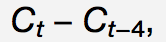

In [563]:
momentum = seconddf.close - seconddf.close.shift(4)
seconddf["momentum"] = momentum
seconddf.tail()

,open,high,low,close,momentum
date,,,,,
2019-12-27,1.11004,1.11873,1.10992,1.11713,0.00796
2019-12-28,1.11739,1.11838,1.11734,1.11813,0.00940
2019-12-29,1.11739,1.11838,1.11734,1.11813,0.00869
2019-12-30,1.11807,1.12200,1.11807,1.12013,0.01001
2019-12-31,1.12014,1.12277,1.12003,1.12277,0.00564


### Stochastic %K  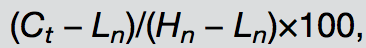

In [564]:
Stochastic = ((seconddf.close - seconddf.low)/((seconddf.high.rolling(window=10).max()) - (seconddf.low.rolling(window=10).min())))*100
seconddf["stochastic"] = Stochastic
seconddf.tail()

,open,high,low,close,momentum,stochastic
date,,,,,,
2019-12-27,1.11004,1.11873,1.10992,1.11713,0.00796,59.734880
2019-12-28,1.11739,1.11838,1.11734,1.11813,0.00940,6.545153
2019-12-29,1.11739,1.11838,1.11734,1.11813,0.00869,6.545153
2019-12-30,1.11807,1.12200,1.11807,1.12013,0.01001,13.705921
2019-12-31,1.12014,1.12277,1.12003,1.12277,0.00564,17.341772


## Normalizing data

In [565]:
def normalizeDf(df):
    
    normalizedDf = pd.seconddf()
    
    for column in seconddf:
        normalizedDf[column] = normalizeColumn(seconddf, column)
               
    return normalizedDf.set_index(seconddf.index)

In [566]:
seconddf.tail()

,open,high,low,close,momentum,stochastic
date,,,,,,
2019-12-27,1.11004,1.11873,1.10992,1.11713,0.00796,59.734880
2019-12-28,1.11739,1.11838,1.11734,1.11813,0.00940,6.545153
2019-12-29,1.11739,1.11838,1.11734,1.11813,0.00869,6.545153
2019-12-30,1.11807,1.12200,1.11807,1.12013,0.01001,13.705921
2019-12-31,1.12014,1.12277,1.12003,1.12277,0.00564,17.341772


### Create a label for your forecast, by shifting the close value n steps

In [567]:
seconddf.insert(1, "forecast", (seconddf["close"].shift(-4)))
seconddf.tail()

,open,forecast,high,low,close,momentum,stochastic
date,,,,,,,
2019-12-27,1.11004,1.12277,1.11873,1.10992,1.11713,0.00796,59.734880
2019-12-28,1.11739,NaN,1.11838,1.11734,1.11813,0.00940,6.545153
2019-12-29,1.11739,NaN,1.11838,1.11734,1.11813,0.00869,6.545153
2019-12-30,1.11807,NaN,1.12200,1.11807,1.12013,0.01001,13.705921
2019-12-31,1.12014,NaN,1.12277,1.12003,1.12277,0.00564,17.341772


### Dropping data again

In [568]:
seconddf.drop(["open","high","low"], inplace=True, axis=1)
seconddf.tail()

,forecast,close,momentum,stochastic
date,,,,
2019-12-27,1.12277,1.11713,0.00796,59.734880
2019-12-28,NaN,1.11813,0.00940,6.545153
2019-12-29,NaN,1.11813,0.00869,6.545153
2019-12-30,NaN,1.12013,0.01001,13.705921
2019-12-31,NaN,1.12277,0.00564,17.341772


In [569]:
seconddf.tail()

,forecast,close,momentum,stochastic
date,,,,
2019-12-27,1.12277,1.11713,0.00796,59.734880
2019-12-28,NaN,1.11813,0.00940,6.545153
2019-12-29,NaN,1.11813,0.00869,6.545153
2019-12-30,NaN,1.12013,0.01001,13.705921
2019-12-31,NaN,1.12277,0.00564,17.341772


## Training data

#### (Dropping NaN content)

In [570]:
seconddf = seconddf.dropna()

In [571]:
#We split the data 0.8/0.2
n = seconddf.shape[0]
train_size = 0.8
train_df = seconddf.iloc[:int(n * train_size)]
test_df = seconddf.iloc[int(n * train_size):]

print("Train rows:", len(train_df),"Test rows:", len(test_df))
print("Total rows:", len(seconddf))

Train rows: 2911 Test rows: 728
Total rows: 3639


#### Continuing my mission

In [572]:
#svr = SVR()
#rf = RandomForestRegressor()
lr = LinearRegression()

y_train = np.array(train_df['forecast'])
x_train = np.array(train_df[['close', 'momentum', 'stochastic']])

lr.fit(x_train, y_train)

y_test = np.array(test_df['forecast'])
x_test = np.array(test_df[['close', 'momentum', 'stochastic']])

### If i did this right this is the accuracy of my forecast

In [573]:
print(lr.score(x_test, y_test))

0.9688988659518245


### Calculate the RSME error

In [574]:
print("the RSME error for traindata:",np.sqrt((train_df['close'] - train_df['forecast']) ** 2).mean()*100)

the RSME error for traindata: 0.9561700446581914


In [575]:
print("the RSME error for testdata:",np.sqrt((test_df['close'] - test_df['forecast']) ** 2).mean()*100)

the RSME error for testdata: 0.5736236263736267


### Calculate R^2 error

In [576]:
r2 = r2_score(train_df['close'], train_df['forecast']) 
print('r2 score for train is', r2) 

r2 score for train is 0.9879123912470714


In [577]:
r2 = r2_score(test_df['close'], test_df['forecast']) 
print('r2 score for test is', r2) 

r2 score for test is 0.9690178544514596


This means that 96,90% of the values are accounted for. If it would be 1.00 there would not be any mistakes in the prediction.

### Calculate thw MASE error

In [578]:
print('mase for test: ', np.mean(np.abs(test_df['close'] - test_df['forecast']))/np.mean(np.abs(np.diff(test_df['close']))))
print('mase for train: ', np.mean(np.abs(train_df['close'] - train_df['forecast']))/np.mean(np.abs(np.diff(train_df['close']))))


mase for test:  2.232643822435559
mase for train:  2.2740128457906885


### Calculate MAPE error

In [579]:
print("MAPE on train", np.mean(np.abs((train_df['forecast'] - train_df['close']) / train_df['forecast'])*100))

MAPE on train 0.7654697482864209


In [580]:
print("MAPE on test", np.mean(np.abs((test_df['forecast'] - test_df['close']) / test_df['forecast'])*100))

MAPE on test 0.49615368350132605
